### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1-score > 0.5 на private Leaderboard
* F1-score_1, recall_1, precision_1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Импорт необходимых библиотек**

In [1]:
from pathlib import Path
import os

import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [2]:
# input
TRAIN_DATASET_PATH = 'C:/Users/User/GeekBrains/II_четверть/Python_lab_for_Data_Sience_part_2/lesson_4/data/course_project/course_project_train.csv'
TEST_DATASET_PATH = 'C:/Users/User/GeekBrains/II_четверть/Python_lab_for_Data_Sience_part_2/lesson_4/data/course_project/course_project_test.csv'

# output
SAMPLE_SUBMIT_PATH = 'C:/Users/User/GeekBrains/II_четверть/Python_lab_for_Data_Sience_part_2/lesson_4/hw_4/files/credit_default_submit.csv'

**Загрузка данных**

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Для удобства в дальнейшем анализе  названия столбцов приведем в более читаемый стиль snake_case. 

In [4]:
def convert_col(col):
    return re.sub(r'(?<!^) (?=[a-zA-Z])', '_', col).lower()
df_train.columns = map(convert_col, df_train.columns)
df_test.columns = map(convert_col, df_test.columns)

In [5]:
df_train.head(10)

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


### Обзор данных<a class="anchor" id="review"></a>

In [6]:
# проверка на дисбаланс классов
df_train['credit_default'].value_counts()

0    5387
1    2113
Name: credit_default, dtype: int64

Выявлен дисбаланс классов

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7129 non-null   object 
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  3419 non-null   float64
 9   bankruptcies                  7486 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  cur

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                2500 non-null   object 
 1   annual_income                 1987 non-null   float64
 2   years_in_current_job          2414 non-null   object 
 3   tax_liens                     2500 non-null   float64
 4   number_of_open_accounts       2500 non-null   float64
 5   years_of_credit_history       2500 non-null   float64
 6   maximum_open_credit           2500 non-null   float64
 7   number_of_credit_problems     2500 non-null   float64
 8   months_since_last_delinquent  1142 non-null   float64
 9   bankruptcies                  2497 non-null   float64
 10  purpose                       2500 non-null   object 
 11  term                          2500 non-null   object 
 12  current_loan_amount           2500 non-null   float64
 13  cur

Есть пропуски данных для следующих количественных признаков:
 - Annual Income
 - Months since last delinquent
 - Bankruptcies
 - Credit Score

Есть пропуски данных для следующих категориальных признаков:
 - Years in current job

**Обзор количественных признаков**

In [9]:
df_train.describe()

,annual_income,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор категориальных признаков**

* **Home Ownership** - домовладение
* **Years in current job** - количество лет на текущем месте работы
* **Purpose** - цель кредита
* **Term** - срок кредита

In [10]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

home_ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: home_ownership, dtype: int64
****************************************************************************************************

years_in_current_job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: years_in_current_job, dtype: int64
****************************************************************************************************

purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [11]:
df_train.isna().sum()

home_ownership                     0
annual_income                   1557
years_in_current_job             371
tax_liens                          0
number_of_open_accounts            0
years_of_credit_history            0
maximum_open_credit                0
number_of_credit_problems          0
months_since_last_delinquent    4081
bankruptcies                      14
purpose                            0
term                               0
current_loan_amount                0
current_credit_balance             0
monthly_debt                       0
credit_score                    1557
credit_default                     0
dtype: int64

In [12]:
df_test.isna().sum()

home_ownership                     0
annual_income                    513
years_in_current_job              86
tax_liens                          0
number_of_open_accounts            0
years_of_credit_history            0
maximum_open_credit                0
number_of_credit_problems          0
months_since_last_delinquent    1358
bankruptcies                       3
purpose                            0
term                               0
current_loan_amount                0
current_credit_balance             0
monthly_debt                       0
credit_score                     513
dtype: int64

**Все пропуски будем менять на медианное значение.**

In [13]:
# df_train
df_train['credit_score'] = df_train['credit_score'].fillna(df_train['credit_score'].median())
df_train['annual_income'] = df_train['annual_income'].fillna(df_train['annual_income'].median())
df_train['months_since_last_delinquent'] = df_train['months_since_last_delinquent'].fillna(df_train['months_since_last_delinquent'].median())
df_train['bankruptcies'] = df_train['bankruptcies'].fillna(df_train['bankruptcies'].median())
df_train['years_in_current_job'] = df_train['years_in_current_job'].fillna(df_train['years_in_current_job'].mode()[0])

In [14]:
# df_test
df_test['credit_score'] = df_test['credit_score'].fillna(df_test['credit_score'].median())
df_test['annual_income'] = df_test['annual_income'].fillna(df_test['annual_income'].median())
df_test['months_since_last_delinquent'] = df_test['months_since_last_delinquent'].fillna(df_test['months_since_last_delinquent'].median())
df_test['bankruptcies'] = df_test['bankruptcies'].fillna(df_test['bankruptcies'].median())
df_test['years_in_current_job'] = df_test['years_in_current_job'].fillna(df_test['years_in_current_job'].mode()[0])

**Присвоение категориальным признакам числовых значений**

**Home Ownership**

Было:

Home Mortgage    
Rent             
Own Home         
Have Mortgage  

Стало:

Mortgage (Home Mortgage, Have Mortgage) - 1    
Rent (Rent) - 2             
Own (Own Home) - 0

**Years in current job**

Было:

10+ years    
2 years       
3 years       
< 1 year     
5 years       
1 year        
4 years      
6 years      
7 years      
8 years       
9 years       

Стало:

5 years and less (< 1 year, 1 year, 2 year, 3 year, 4 year, 5 years) - 0

more then 5 years
 less then 10 (6 year, 7 year, 8 year, 9 year)	 - 1
	
10 years and more (10+ years) - 2


**Purpose**

Было:

debt consolidation      	
other 	
home improvements        	
business loan            	
buy a car                 	
medical bills             	
major purchase            	
take a trip               	
buy house                 	
small business            	
wedding                   	
moving                    	
educational expenses      	
vacation                  	
renewable energy           	

Стало:

debt (debt consolidation) - 0

bisiness (business loan, small business) - 1

other (other, medical bills, educational expenses) - 5

new home (home improvements, buy house, moving) - 2

major purchase (buy a car, major purchase, renewable energy) - 3 


vacation (take a trip, wedding, vacation) - 4

**Term**

Short Term - 0

Long Term - 1


In [15]:
def convert_feat_to_int_do_less_feat(data_frame):
    cat_feat = data_frame.select_dtypes(include='object').columns[0:]
    for feature_name in cat_feat:
        if feature_name == 'home_ownership':
            for unique_name in data_frame[feature_name].unique().tolist():
                if unique_name in morgage:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 1,}
                    }, inplace=True)
                elif unique_name == 'Rent':
                    data_frame.replace({
                        feature_name: {
                            unique_name: 2,}
                    }, inplace=True)
                else:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 0,}
                    }, inplace=True)
        if feature_name == 'years_in_current_job': 
            for unique_name in data_frame[feature_name].unique().tolist():
                if unique_name in years_5_and_less:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 0,}
                    }, inplace=True)
                elif unique_name in more_then_5_years_less_then_10:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 1,}
                    }, inplace=True)
                else:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 2,}
                    }, inplace=True)
        if feature_name == 'purpose':
            for unique_name in data_frame[feature_name].unique().tolist():
                if unique_name in bisiness:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 1,}
                    }, inplace=True)
                elif unique_name in other:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 5,}
                    }, inplace=True)
                elif unique_name in new_home:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 2,}
                    }, inplace=True)
                elif unique_name in major_purchase:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 3,}
                    }, inplace=True)
                elif unique_name in vacation:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 4,}
                    }, inplace=True)
                else:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 0,}
                    }, inplace=True)
        if feature_name == 'term':
            for unique_name in data_frame[feature_name].unique().tolist():
                if unique_name == 'Short Term':
                    data_frame.replace({
                        feature_name: {
                            unique_name: 0,}
                    }, inplace=True)
                else:
                    data_frame.replace({
                        feature_name: {
                            unique_name: 1,}
                    }, inplace=True)
    return data_frame

In [16]:
morgage = ['Home Mortgage', 'Have Mortgage']
years_5_and_less = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years']
more_then_5_years_less_then_10 = ['6 years', '7 years', '8 years', '9 years']
years_10_and_more = ['10+ years']
debt  = ['debt consolidation']
bisiness = ['business loan', 'small business']
other = ['other', 'medical bills', 'educational expenses']
new_home = ['home improvements', 'buy house', 'moving']
major_purchase = ['buy a car', 'major purchase', 'renewable energy']
vacation = ['take a trip', 'wedding', 'vacation']

In [17]:
df_train = convert_feat_to_int_do_less_feat(df_train)
df_test = convert_feat_to_int_do_less_feat(df_test)

In [18]:
df_train.head(10)

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
0,0,482087.0,2,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,0,0,99999999.0,47386.0,7914.0,749.0,0
1,0,1025487.0,2,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,0,1,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,1,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,0,0,99999999.0,308389.0,13651.0,742.0,0
3,0,805068.0,1,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,0,0,121396.0,95855.0,11338.0,694.0,0
4,2,776264.0,1,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,0,0,125840.0,93309.0,7180.0,719.0,0
5,2,1168386.0,1,0.0,12.0,14.6,366784.0,0.0,32.0,0.0,5,1,337304.0,165680.0,18692.0,731.0,1
6,1,1511108.0,2,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,2,0,99999999.0,51623.0,2317.0,745.0,0
7,2,1040060.0,2,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,5,0,250888.0,89015.0,19761.0,705.0,1
8,1,1168386.0,0,0.0,17.0,15.7,0.0,1.0,32.0,1.0,2,0,129734.0,19.0,17.0,731.0,0
9,1,1168386.0,0,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,0,1,572880.0,205333.0,17613.0,731.0,1


**Выделение целевой переменной и групп признаков**

In [20]:
TARGET = 'credit_default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET).tolist()
CAT_FEATURE_NAMES = [
    'home_ownership', 'years_in_current_job', 'purpose', 'term']
    #'tax_liens', 'number_of_open_accounts', 'number_of_credit_problems','months_since_last_delinquent', 'bankruptcies']

**Корреляция таргета с базовыми признаками**

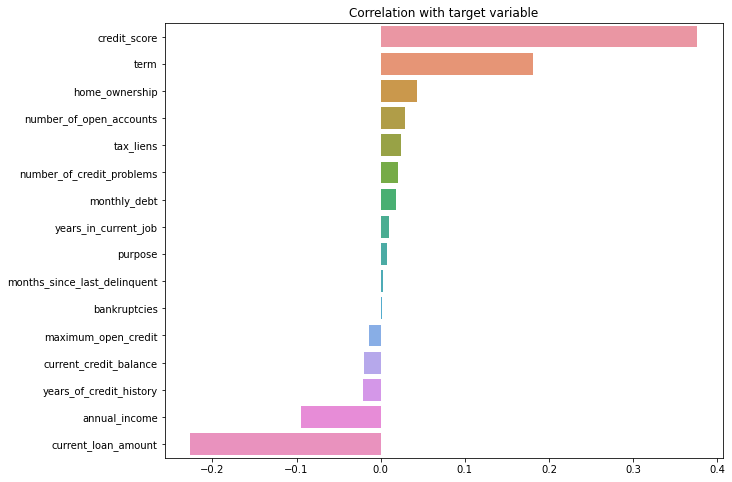

In [21]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Признаки credit_score, term и current_loan_amount имеют наибольшие корреляции с таргетом

**Матрица корреляций**

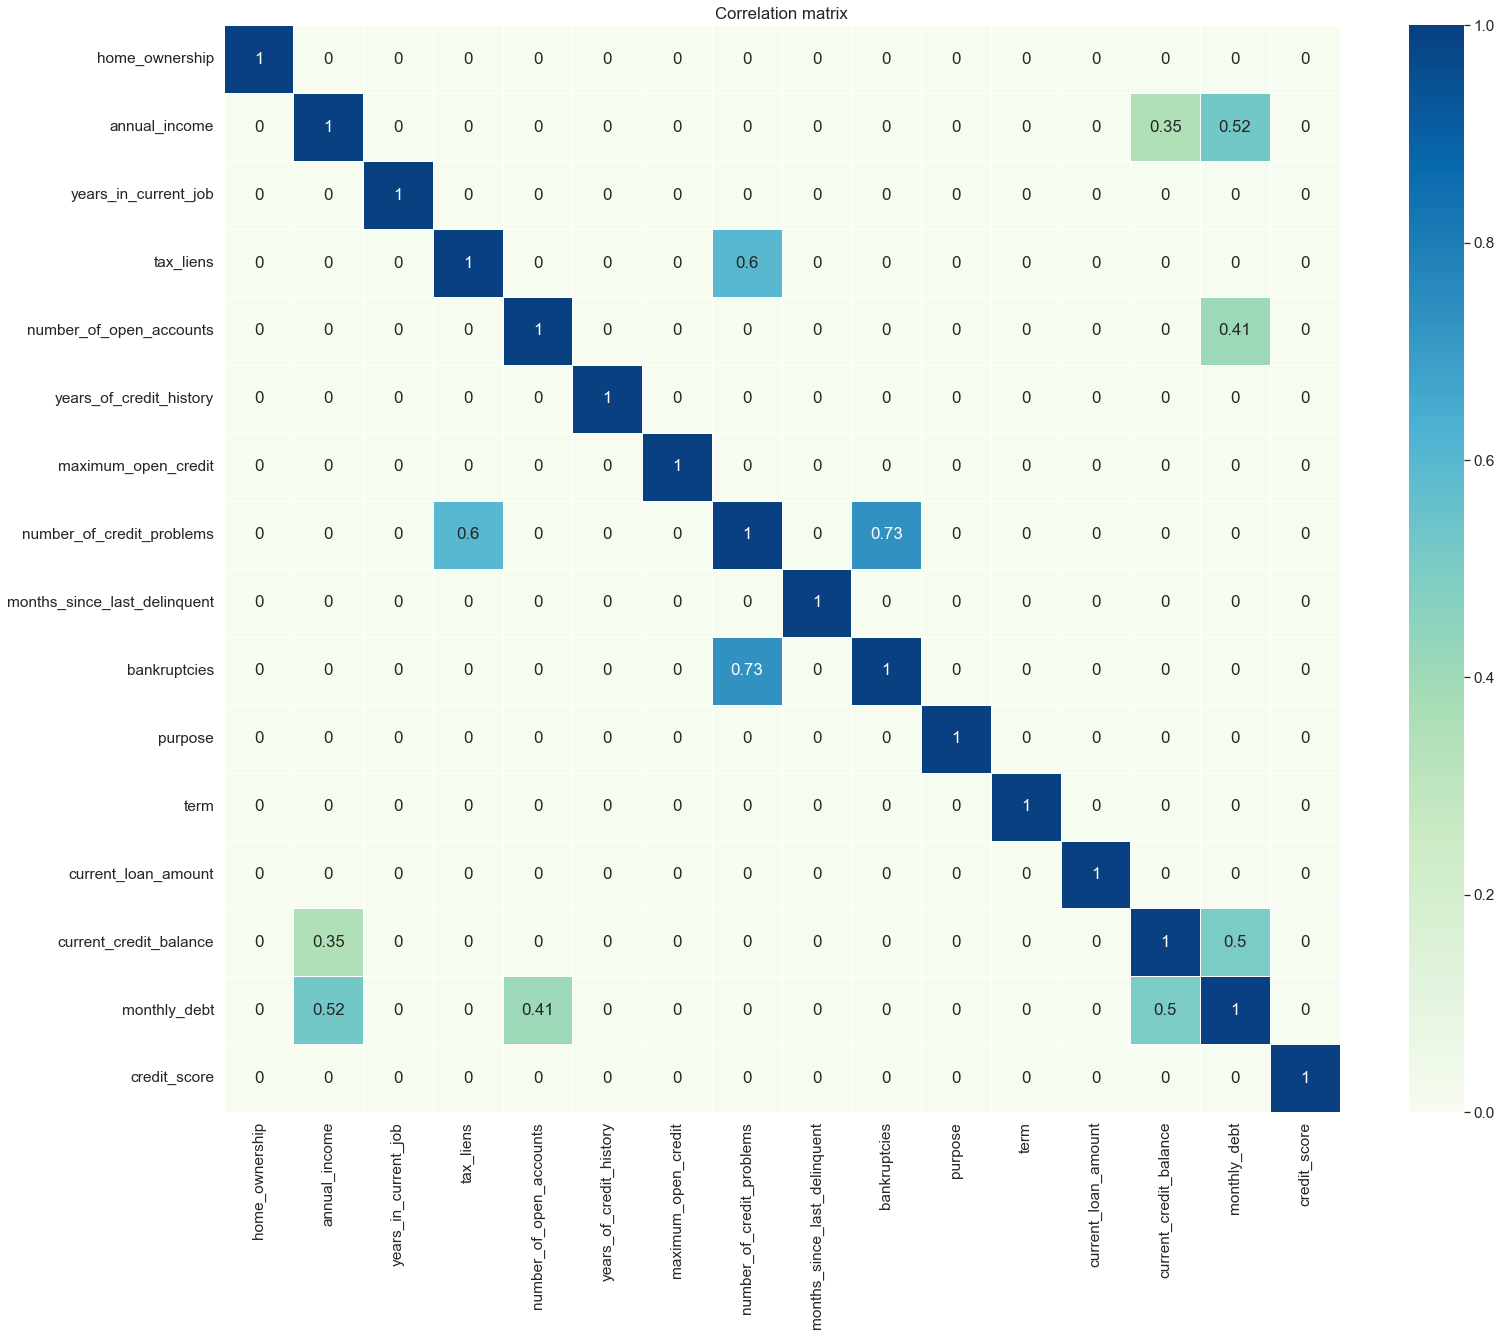

In [23]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.4)

corr_matrix = df_train[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Переводим формат

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   int64  
 1   annual_income                 7500 non-null   float64
 2   years_in_current_job          7500 non-null   int64  
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  7500 non-null   float64
 9   bankruptcies                  7500 non-null   float64
 10  purpose                       7500 non-null   int64  
 11  term                          7500 non-null   int64  
 12  current_loan_amount           7500 non-null   float64
 13  cur

**Обучение моделей**

In [25]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [26]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [34]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [27]:
df = df_train.copy()
X = df_train.drop(TARGET, axis=1)
y = df[TARGET]

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

In [29]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5502958579881656

In [31]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [32]:
model_catb = catb.CatBoostClassifier(**frozen_params)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4310
           1       0.53      0.69      0.60      1690

    accuracy                           0.74      6000
   macro avg       0.70      0.73      0.71      6000
weighted avg       0.77      0.74      0.75      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1077
           1       0.51      0.64      0.57       423

    accuracy                           0.73      1500
   macro avg       0.68      0.70      0.68      1500
weighted avg       0.75      0.73      0.73      1500

CONFUSION MATRIX

col_0             0    1
credit_default          
0               817  260
1               151  272


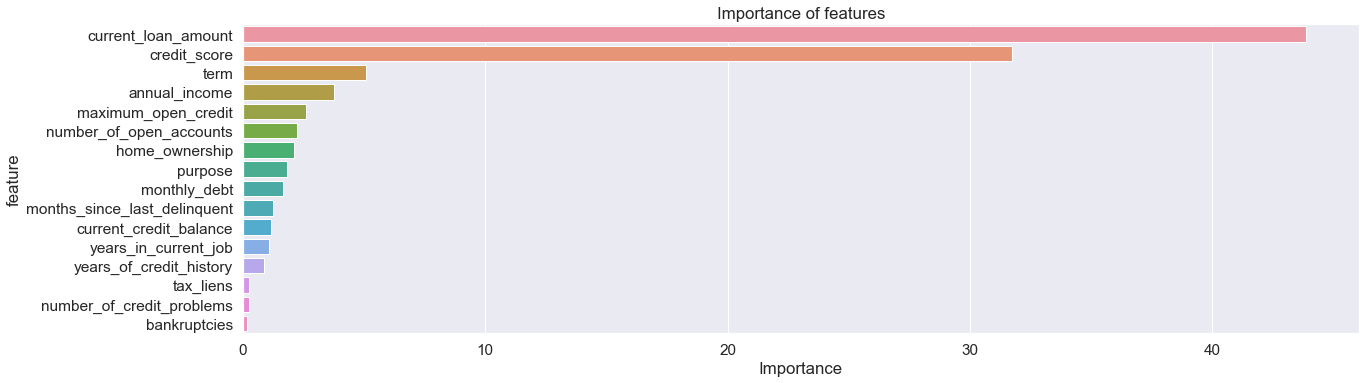

In [35]:
important_features_top = show_feature_importances(X_train.columns,
                                                  model_catb.feature_importances_, get_top=30)

Признаки, у которых была наибольшая корреляция с таргетом, credit_score, term и current_loan_amount имеют максимальную важность. 

In [36]:
X_test = df_test.copy()

In [37]:
submit = pd.read_csv(SAMPLE_SUBMIT_PATH)

In [38]:
submit['Credit Default'] = model_catb.predict(X_test)
submit.to_csv('credit_default_submit.csv', index=False)